In [2]:
# PUNTI CRITICI
# NON TIENE CONTO DELLA CONTEMPORANEITA' POSSIBILE DI ALCUNE OPERAZIONI: SE LA SECONDA OPERAZIONE APRE MENTRE LA PRIMA NON HA ANCORA CHIUSO DEL TUTTO,
# IL BALANCE SU CUI SI BASA LA SECONDA OPERAZIONE DOVREBBE ESSERE LO STESSO SUL QUALE SI E' BASATA LA PRIMA -> EVITARE INTERESSE COMPOSTO E BASARSI SEMPRE
# SU BALANCE 10000 PUO' ESSERE UNA SOLUZIONE (SOTTOSTIMA IL GUADAGNO EFFETTIVO SE SIAMO OLTRE I 10K, SOVRASTIMA SE SIAMO SOTTO)

# NON PUO' TENERE TRACCIA DELL'EQUITY (PER LE PROP) POICHE' NON SAPPIAMO IL DRAWDOWN MA SOLO SE E' ANDATO A SL -> TENENDO UN RISCHIO BASSO E VALUTANDO QUANTE
# POSSIBILI OPERAZIONI IN CONTEMPORANEA POTREBBERO ESSERCI, NON DOVREBBERO ESSERCI PROBLEMI

In [3]:
# importo i dati, seleziono i formatori e unisco le statistiche (ordinandole per data)

import pandas as pd
from datetime import datetime

statistiche=[]
formatori = ['NATE', 'REY', 'DAVID']

for k in range(len(formatori)):
    curr_stats = pd.read_excel('TitanPython.xlsx', sheet_name=f'{formatori[k]} XAUUSD' )
    curr_stats['FORMATORE']=formatori[k]
    curr_stats['DATA_ORA']=curr_stats.apply(lambda row: datetime.combine(row['GIORNO'].date(), row['ORA']), axis=1)
    statistiche.append(curr_stats)

statistiche_unito = pd.concat([statistiche[j] for j in range(len(formatori))])
statistiche_unito = statistiche_unito.sort_values(by='DATA_ORA')

# filtro le statistiche per data, imposto alcuni parametri e valuto la strategia

startDate = pd.Timestamp('2024-01-02')
endDate = pd.Timestamp('2025-04-16')
formatore_risk = {'NATE': 0.5, 'REY': 0.5, 'DAVID': 0.5}    #scegli il rischio da usare per ogni operazione per ogni formatore (1 = 1%; 0.5 = 0.5% e così via)
formatore_rr = {'NATE': [1], 'REY': [3], 'DAVID': [1]}  #scegli il RR della strategia per ogni formatore (1:1, 1:1.5, 1:2,...)
formatore_parziali = {'NATE': [1], 'REY': [1], 'DAVID': [1]} # scegli i parziali per ogni formatore

statistiche_filtered = statistiche_unito.copy()
statistiche_filtered = statistiche_filtered[(statistiche_filtered['GIORNO'] >= startDate) & (statistiche_filtered['GIORNO'] <= endDate)]
statistiche_filtered = statistiche_filtered.reset_index(drop=True)
balance_array=[]
previous_balance = 10000
balance_array.append(previous_balance)
updated_balance = 0


for i in range(len(statistiche_filtered)):
    curr_date=statistiche_filtered['GIORNO'][i].date()
    curr_hour=statistiche_filtered['ORA'][i]
    curr_direction = statistiche_filtered['DIREZIONE'][i]
    curr_max_rr=statistiche_filtered['RR MAX'][i]
    curr_formatore = statistiche_filtered['FORMATORE'][i]
    risk = formatore_risk[curr_formatore]
    rr_desired_list = formatore_rr[curr_formatore]
    parziali = formatore_parziali[curr_formatore]

    print(f'Initial balance: {int(previous_balance)}. Operazione di {curr_formatore} del {curr_date}, ora {curr_hour}, direzione: {curr_direction}')

    curr_operation_pnl=0 #tiene aggiornato il profit/loss dell'operazione corrente
    percentage_open = 1 #tiene aggiornata la percentuale di posizione ancora aperta

    for j in range(len(rr_desired_list)):
        curr_rr_desired = rr_desired_list[j]
        if(curr_max_rr>=curr_rr_desired):
            percentage_open = percentage_open - parziali[j]
            curr_operation_pnl = curr_operation_pnl + (risk/100) * curr_rr_desired * parziali[j] * previous_balance
            print(f'TP 1:{curr_rr_desired} con parziale {parziali[j]*100}% preso. Position still open: {percentage_open*100}%.')
        else:
            curr_operation_pnl = curr_operation_pnl - (risk/100) * percentage_open * previous_balance
            print(f'SL hit!')
            break

    updated_balance = previous_balance + curr_operation_pnl
    print(f'PnL of the operation: {round(curr_operation_pnl,2)}. New balance: {round(updated_balance,2)}.')
    previous_balance = updated_balance

    balance_array.append(updated_balance)



Initial balance: 10000. Operazione di NATE del 2024-01-02, ora 21:16:00, direzione: S
TP 1:1 con parziale 100% preso. Position still open: 0%.
PnL of the operation: 50.0. New balance: 10050.0.
Initial balance: 10050. Operazione di NATE del 2024-01-03, ora 20:03:00, direzione: L
SL hit!
PnL of the operation: -50.25. New balance: 9999.75.
Initial balance: 9999. Operazione di DAVID del 2024-01-03, ora 21:13:00, direzione: L
TP 1:1 con parziale 100% preso. Position still open: 0%.
PnL of the operation: 50.0. New balance: 10049.75.
Initial balance: 10049. Operazione di NATE del 2024-01-04, ora 10:28:00, direzione: L
TP 1:1 con parziale 100% preso. Position still open: 0%.
PnL of the operation: 50.25. New balance: 10100.0.
Initial balance: 10099. Operazione di DAVID del 2024-01-04, ora 22:38:00, direzione: L
TP 1:1 con parziale 100% preso. Position still open: 0%.
PnL of the operation: 50.5. New balance: 10150.5.
Initial balance: 10150. Operazione di NATE del 2024-01-05, ora 08:11:00, direzi

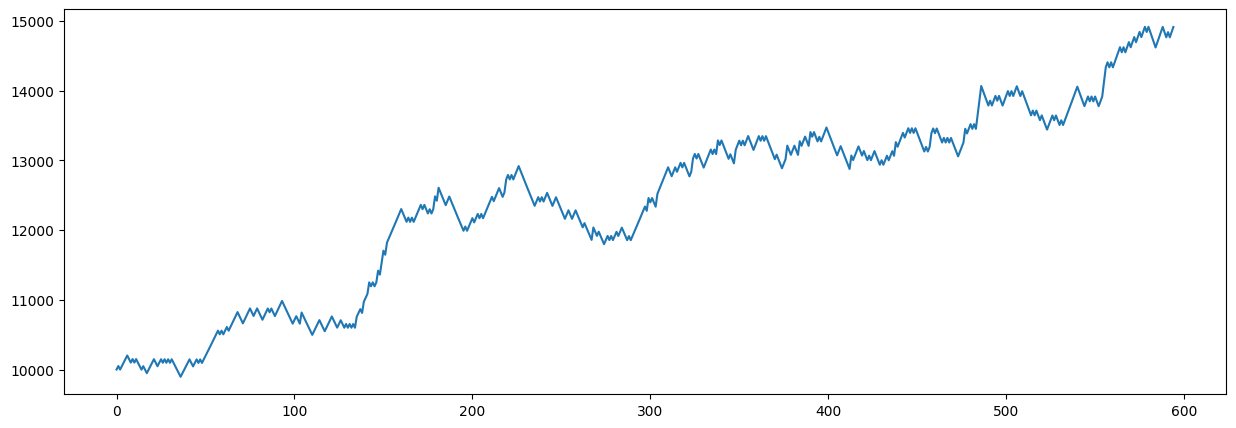

In [4]:
# VISUALIZZAZIONE ANDAMENTO BALANCE

import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(balance_array)

In [5]:
# VISUALIZZAZIONE DISTRIBUZIONI RR